# Supervised learning - Regression
Goal of the excercise is to learn how to use Scikit-learn library for a regression tasks employing various linear regression models and moreover evaluate the performance of the proposed models.

## Models
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LinearRegression.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Ridge.html#sklearn.linear_model.Ridge
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html#sklearn.linear_model.Lasso
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet

## Preprocessing methods
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler
- https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html#sklearn.preprocessing.PowerTransformer

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet

from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler

In [2]:
"""
Computes MAPE
"""
def mean_absolute_percentage_error(y_true: np.array, y_pred: np.array) -> float:
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def compute_metrics(df: pd.DataFrame) -> pd.DataFrame:
    y_true, y_pred = df['y_true'].values, df['y_pred'].values
    return compute_metrics_raw(y_true, y_pred)

def compute_metrics_raw(y_true: pd.Series, y_pred: pd.Series) -> pd.DataFrame:
    mae, mse, rmse, mape = mean_absolute_error(y_true=y_true, y_pred=y_pred), mean_squared_error(y_true=y_true, y_pred=y_pred), np.sqrt(mean_squared_error(y_true=y_true, y_pred=y_pred)), mean_absolute_percentage_error(y_true=y_true, y_pred=y_pred)
    return pd.DataFrame.from_records([{'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'MAPE': mape}], index=[0])

In [3]:
def plot_results(y_test, y_pred):
    df_res = pd.DataFrame({'y_test': y_test, 'y_pred': y_pred})
    df_res_s = df_res.stack().reset_index(name='value').rename({'level_0': 'idx', 'level_1': 'variable'}, axis=1)
    return sns.lineplot(data = df_res_s, x='idx', y='value', hue='variable')

## Dataset
https://www.kaggle.com/hmavrodiev/london-bike-sharing-dataset

### Metadata:
- "timestamp" - timestamp field for grouping the data
- "cnt" - the count of a new bike shares
- "t1" - real temperature in C
- "t2" - temperature in C "feels like"
- "hum" - humidity in percentage
- "windspeed" - wind speed in km/h
- "weathercode" - category of the weather
- "isholiday" - boolean field - 1 holiday / 0 non holiday
- "isweekend" - boolean field - 1 if the day is weekend
- "season" - category field meteorological seasons: 0-spring ; 1-summer; 2-fall; 3-winter.

- "weathe_code" category description:
    - 1 = Clear ; mostly clear but have some values with haze/fog/patches of fog/ fog in vicinity 
    - 2 = scattered clouds / few clouds 
    - 3 = Broken clouds 
    - 4 = Cloudy 
    - 7 = Rain/ light Rain shower/ Light rain 
    - 10 = rain with thunderstorm 
    - 26 = snowfall 
    - 94 = Freezing Fog

In [4]:
df = pd.read_csv('bike_london.csv')
df

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0
...,...,...,...,...,...,...,...,...,...,...
17409,2017-01-03 19:00:00,1042,5.0,1.0,81.0,19.0,3.0,0.0,0.0,3.0
17410,2017-01-03 20:00:00,541,5.0,1.0,81.0,21.0,4.0,0.0,0.0,3.0
17411,2017-01-03 21:00:00,337,5.5,1.5,78.5,24.0,4.0,0.0,0.0,3.0
17412,2017-01-03 22:00:00,224,5.5,1.5,76.0,23.0,4.0,0.0,0.0,3.0


In [5]:
df.dtypes

timestamp        object
cnt               int64
t1              float64
t2              float64
hum             float64
wind_speed      float64
weather_code    float64
is_holiday      float64
is_weekend      float64
season          float64
dtype: object

## Change type of *timestamp* to datetime

In [6]:
df['timestamp'] = pd.to_datetime(df.timestamp)

In [7]:
df.dtypes

timestamp       datetime64[ns]
cnt                      int64
t1                     float64
t2                     float64
hum                    float64
wind_speed             float64
weather_code           float64
is_holiday             float64
is_weekend             float64
season                 float64
dtype: object

In [8]:
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0


## Create new time related features out of the timestamp
- day, month, year, hour

In [9]:
df['day'] = df.timestamp.dt.day
df['month'] = df.timestamp.dt.month
df['year'] = df.timestamp.dt.year
df['hour'] = df.timestamp.dt.hour

In [10]:
df.head()

,timestamp,cnt,t1,t2,hum,wind_speed,weather_code,is_holiday,is_weekend,season,day,month,year,hour
0,2015-01-04 00:00:00,182,3.0,2.0,93.0,6.0,3.0,0.0,1.0,3.0,4,1,2015,0
1,2015-01-04 01:00:00,138,3.0,2.5,93.0,5.0,1.0,0.0,1.0,3.0,4,1,2015,1
2,2015-01-04 02:00:00,134,2.5,2.5,96.5,0.0,1.0,0.0,1.0,3.0,4,1,2015,2
3,2015-01-04 03:00:00,72,2.0,2.0,100.0,0.0,1.0,0.0,1.0,3.0,4,1,2015,3
4,2015-01-04 04:00:00,47,2.0,0.0,93.0,6.5,1.0,0.0,1.0,3.0,4,1,2015,4


## How many values are in the individual years?

In [11]:
df.year.value_counts()

2016    8699
2015    8643
2017      72
Name: year, dtype: int64

## *cnt* is the target variable in our case, let's take a look at the values

<AxesSubplot:xlabel='timestamp', ylabel='cnt'>

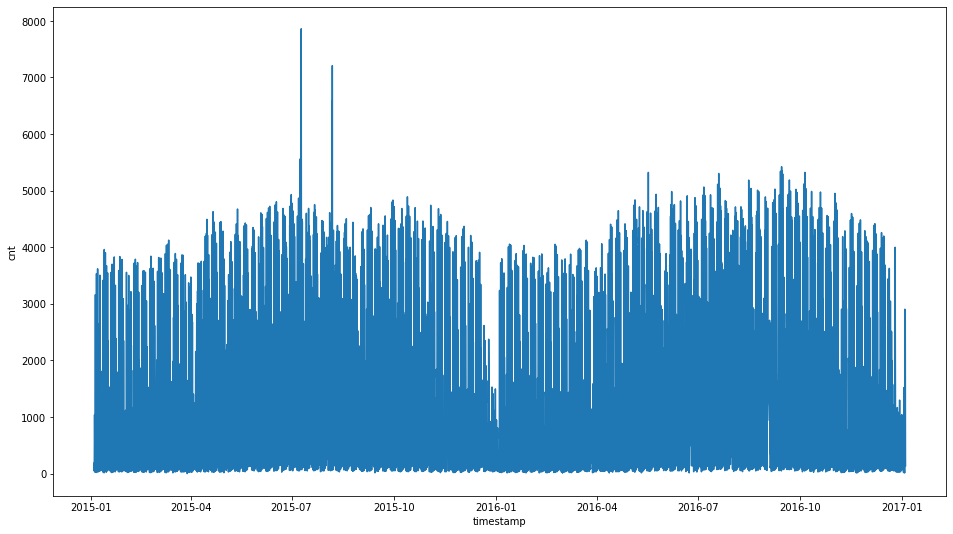

In [12]:
fig = plt.figure(figsize=(16, 9))
sns.lineplot(data=df, x=df.timestamp, y='cnt')

<AxesSubplot:ylabel='cnt'>

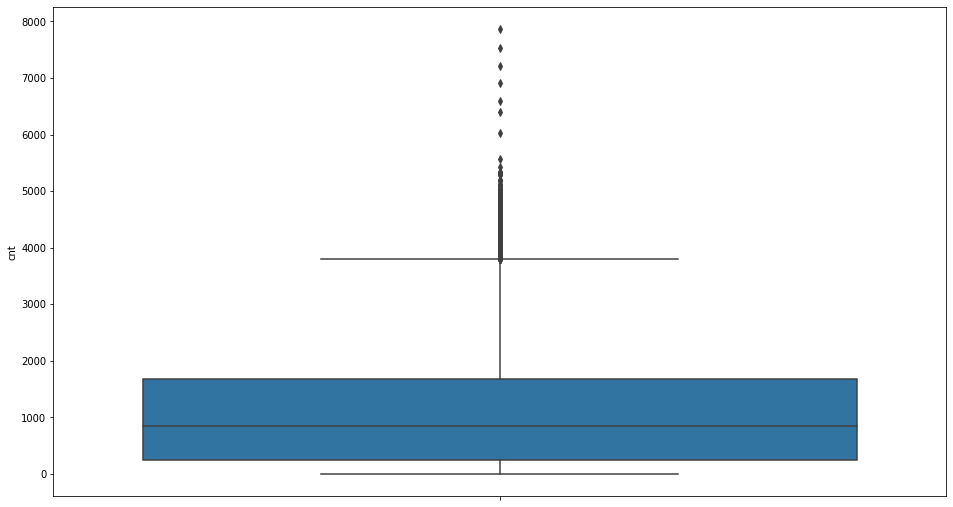

In [13]:
fig = plt.figure(figsize=(16, 9))
sns.boxplot(data=df, y='cnt')

## Split the data into the X and y part

In [24]:
X, y = df.loc[:, (df.columns != 'cnt') & (df.columns != 'timestamp')], df.loc[:, 'cnt']
X.shape, y.shape
# X.head(), y.head()

(    t1   t2    hum  wind_speed  weather_code  is_holiday  is_weekend  season  \
 0  3.0  2.0   93.0         6.0           3.0         0.0         1.0     3.0   
 1  3.0  2.5   93.0         5.0           1.0         0.0         1.0     3.0   
 2  2.5  2.5   96.5         0.0           1.0         0.0         1.0     3.0   
 3  2.0  2.0  100.0         0.0           1.0         0.0         1.0     3.0   
 4  2.0  0.0   93.0         6.5           1.0         0.0         1.0     3.0   
 
    day  month  year  hour  
 0    4      1  2015     0  
 1    4      1  2015     1  
 2    4      1  2015     2  
 3    4      1  2015     3  
 4    4      1  2015     4  ,
 0    182
 1    138
 2    134
 3     72
 4     47
 Name: cnt, dtype: int64)

## We will use first 14000 instances as the training set
- Beware that data are time-related so it is certainly not a great idea to split the data randomly
- Do you know why we shouldn't split the data randomly?

In [15]:
X_train, X_test = X.iloc[:14000, :], X.iloc[14000:, :]
y_train, y_test = y.iloc[:14000], y.iloc[14000:]

In [16]:
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
compute_metrics_raw(y_test, y_pred)

,MAE,MSE,RMSE,MAPE
0,677.767838,949342.051908,974.341856,172.420184


## Vizualize results

<AxesSubplot:xlabel='idx', ylabel='value'>

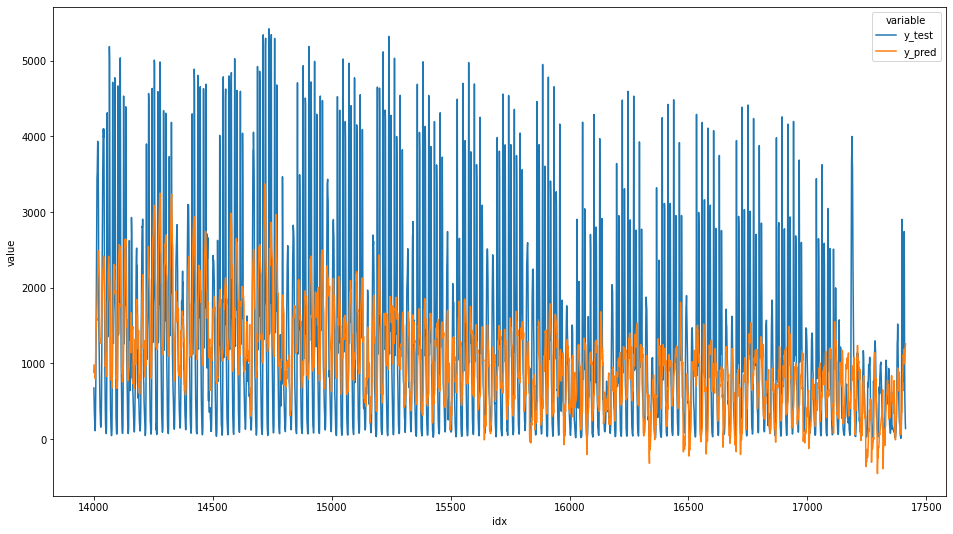

In [17]:
fig = plt.figure(figsize=(16, 9))
plot_results(y_test, y_pred)

## Let's take a look at the coefficient values

In [18]:
reg.coef_

array([  80.66303509,  -26.08877277,  -23.37006737,   -5.40643369,
        -11.78084542, -235.63766894, -203.40269946,   29.13508663,
         -3.29193881,   -7.98917077,   31.12369812,   29.46273458])

<AxesSubplot:>

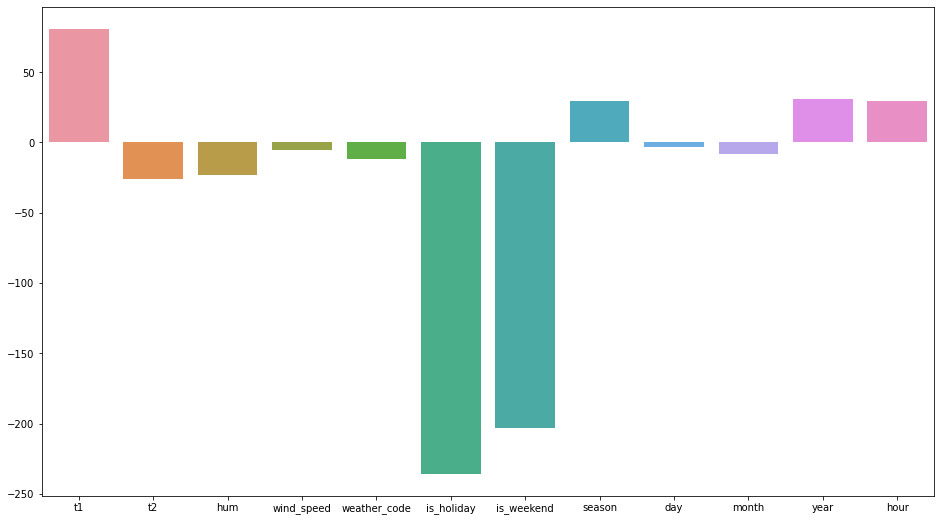

In [19]:
fig = plt.figure(figsize=(16, 9))
sns.barplot(x=X_train.columns, y=reg.coef_)

## Try to apply the [MinMax](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html) scaling to the features and repeat the model fitting

In [20]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [21]:
reg = LinearRegression()
reg.fit(X_train_scaled, y_train)
y_pred = reg.predict(X_test_scaled)
compute_metrics_raw(y_test, y_pred)

,MAE,MSE,RMSE,MAPE
0,677.767838,949342.051908,974.341856,172.420184


## Did the coefficient values change?

In [22]:
reg.coef_

array([ 2863.53774558, -1043.55091094, -1857.920356  ,  -305.4635034 ,
        -294.52113546,  -235.63766894,  -203.40269946,    87.40525989,
         -98.75816444,   -87.88087844,    31.12369812,   677.64289537])

<AxesSubplot:>

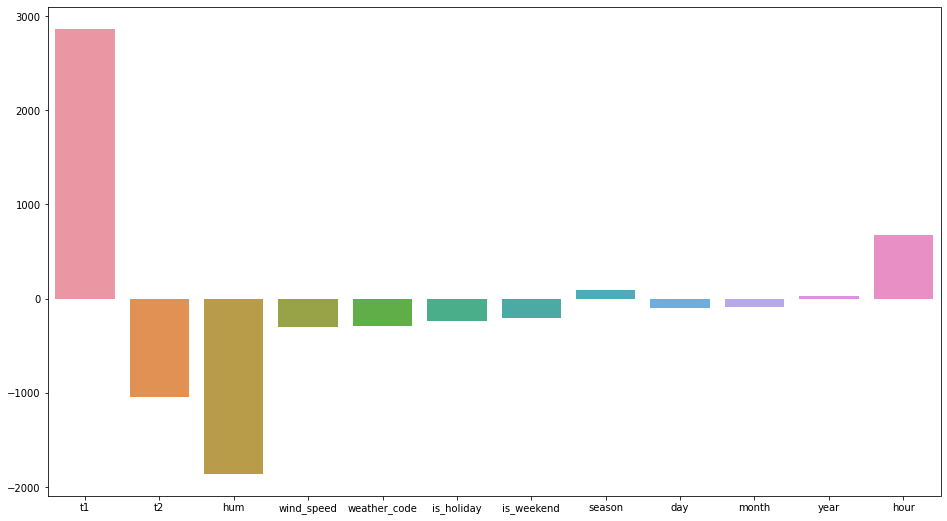

In [23]:
fig = plt.figure(figsize=(16, 9))
sns.barplot(x=X_train.columns, y=reg.coef_)

## Try to apply the [StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) to the features and repeat the model fitting

In [24]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [25]:
reg = LinearRegression()
reg.fit(X_train_scaled, y_train)
y_pred = reg.predict(X_test_scaled)
compute_metrics_raw(y_test, y_pred)

,MAE,MSE,RMSE,MAPE
0,677.767838,949342.051908,974.341856,172.420184


## Did the coefficient values change?

In [26]:
reg.coef_

array([ 441.45892961, -171.1323803 , -334.74638152,  -43.05263793,
        -28.17633144,  -33.44747427,  -91.72176295,   33.91254611,
        -28.92434251,  -25.64122208,   15.12711952,  203.75574827])

<AxesSubplot:>

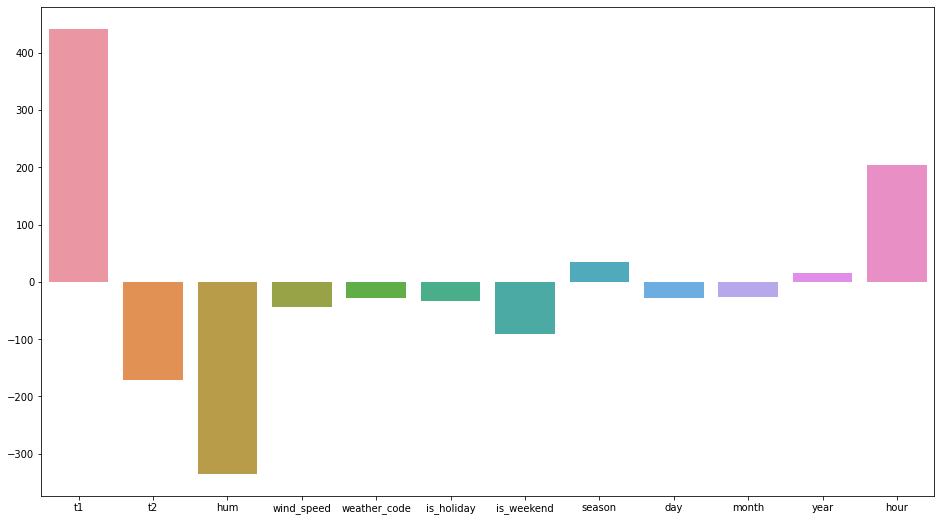

In [27]:
fig = plt.figure(figsize=(16, 9))
sns.barplot(x=X_train.columns, y=reg.coef_)

## Ordinary least squares Linear Regression is the simplest model but there are several other ones which allow us to regularize the coefficient values
- We will start with Lasso (L1) regression and continue with Ridge (L2) regression

In [28]:
reg = Lasso(alpha=1)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
compute_metrics_raw(y_test, y_pred)

,MAE,MSE,RMSE,MAPE
0,677.152644,951137.41857,975.262743,171.332538


## Did the coefficient values change?

In [29]:
reg.coef_

array([  77.76513395,  -23.67598577,  -23.42853146,   -5.31153055,
        -11.64077047, -184.64391553, -196.91728643,   28.68616604,
         -3.32650748,   -8.27447194,   26.31567377,   29.43067619])

<AxesSubplot:>

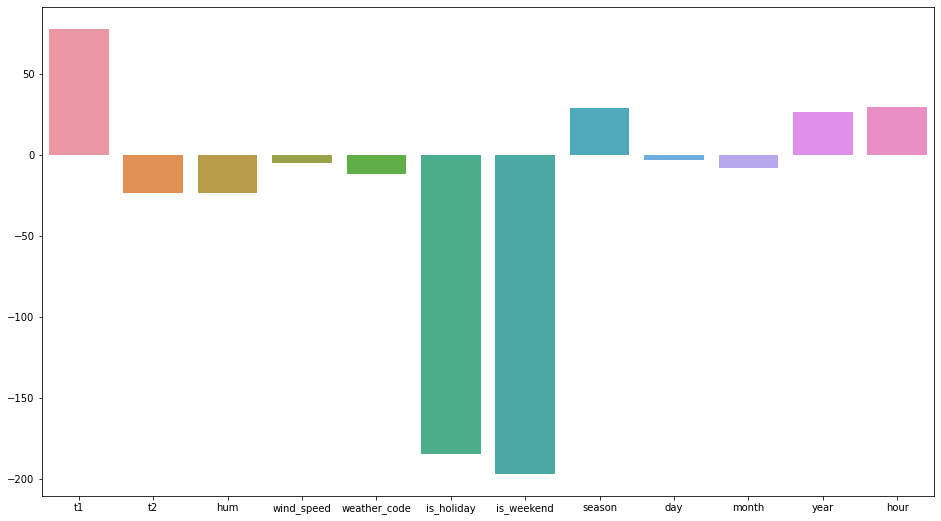

In [30]:
fig = plt.figure(figsize=(16, 9))
sns.barplot(x=X_train.columns, y=reg.coef_)

### Warning: Alpha values are usually set to values between 0 and 1, so we present more extreme cases just for demonstration, 
This is kind of "don't try this at home" section :-)
- Regularization adds a little bit of bias to the model thus the variance (and overfitting) are reduced
- It also helps with co-linearity issues and error amplification in such case
- Lasso regression can help you even with feature selection because it creates a sparse weight vector (some weight are set to 0 if the alpha values is high enough)

### The main point is that regularization adds penalization for a high weight values thus the models is not dependant solely on a single (or couple) of features

In [31]:
reg = Lasso(alpha=10)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
compute_metrics_raw(y_test, y_pred)

,MAE,MSE,RMSE,MAPE
0,673.32276,962465.305041,981.053161,164.643957


In [32]:
reg.coef_

array([  50.7212824 ,   -1.6083792 ,  -23.873317  ,   -4.28639219,
         -9.90009655,   -0.        , -146.45158711,   22.22934514,
         -3.46646962,   -9.48703885,    0.        ,   29.24970861])

<AxesSubplot:>

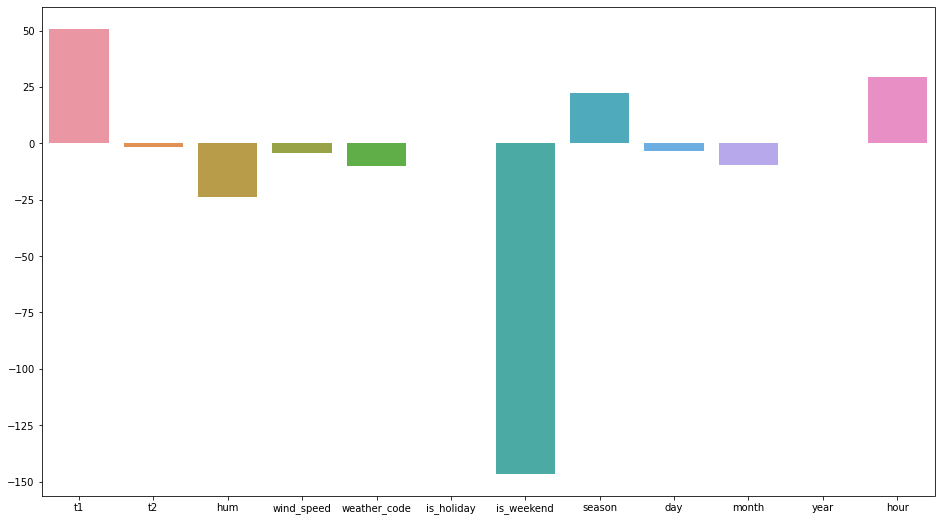

In [33]:
fig = plt.figure(figsize=(16, 9))
sns.barplot(x=X_train.columns, y=reg.coef_)

## Let's try scaling and regularization together

In [34]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [35]:
reg = Lasso(alpha=10)
reg.fit(X_train_scaled, y_train)
y_pred = reg.predict(X_test_scaled)
compute_metrics_raw(y_test, y_pred)

,MAE,MSE,RMSE,MAPE
0,666.928889,948228.328235,973.770162,177.356044


In [36]:
reg.coef_

array([ 1253.30068602,     0.        , -1755.60898452,    -0.        ,
          -0.        ,    -0.        ,  -148.68478828,     0.        ,
          -0.        ,     0.        ,     0.        ,   623.2608792 ])

<AxesSubplot:>

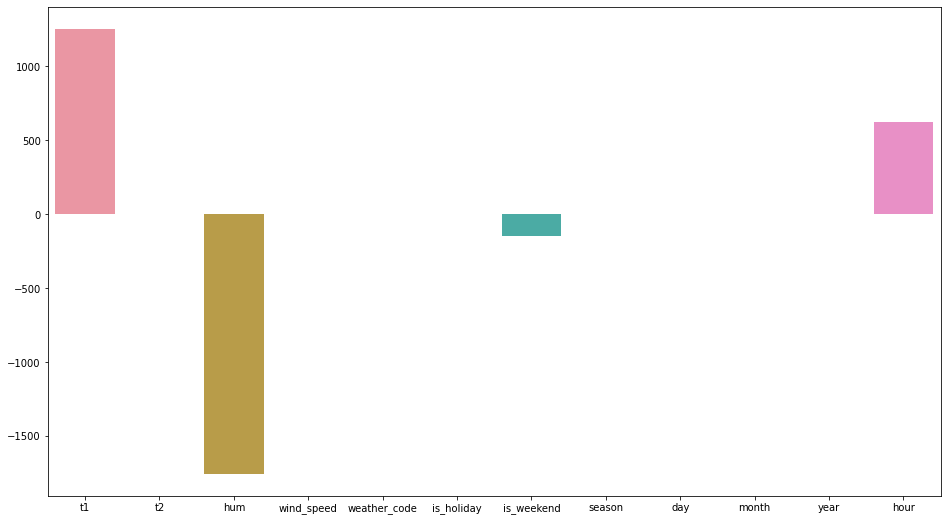

In [37]:
fig = plt.figure(figsize=(16, 9))
sns.barplot(x=X_train.columns, y=reg.coef_)

In [38]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [39]:
reg = Lasso(alpha=10)
reg.fit(X_train_scaled, y_train)
y_pred = reg.predict(X_test_scaled)
compute_metrics_raw(y_test, y_pred)

,MAE,MSE,RMSE,MAPE
0,671.782531,944400.839642,971.802881,170.759123


In [40]:
reg.coef_

array([ 247.24856674,    0.        , -336.15234566,  -18.68799522,
        -21.02584194,  -25.6182081 ,  -80.61761108,   14.93118766,
        -20.33560332,   -9.95165504,    9.61933765,  196.96977645])

<AxesSubplot:>

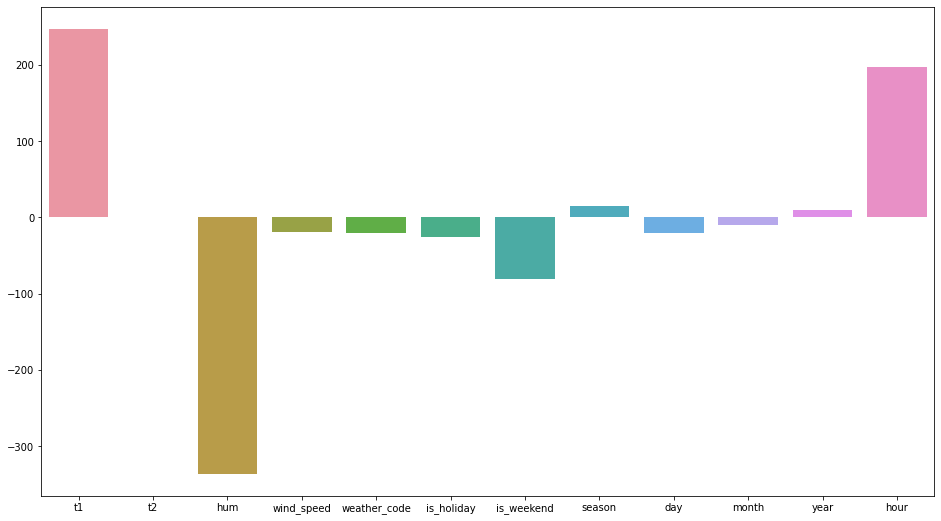

In [41]:
fig = plt.figure(figsize=(16, 9))
sns.barplot(x=X_train.columns, y=reg.coef_)

## Try different alpha values for the Ridge regression as well

In [42]:
reg = Ridge(alpha=0.1)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
compute_metrics_raw(y_test, y_pred)

,MAE,MSE,RMSE,MAPE
0,677.767776,949343.259773,974.342476,172.42006


<AxesSubplot:>

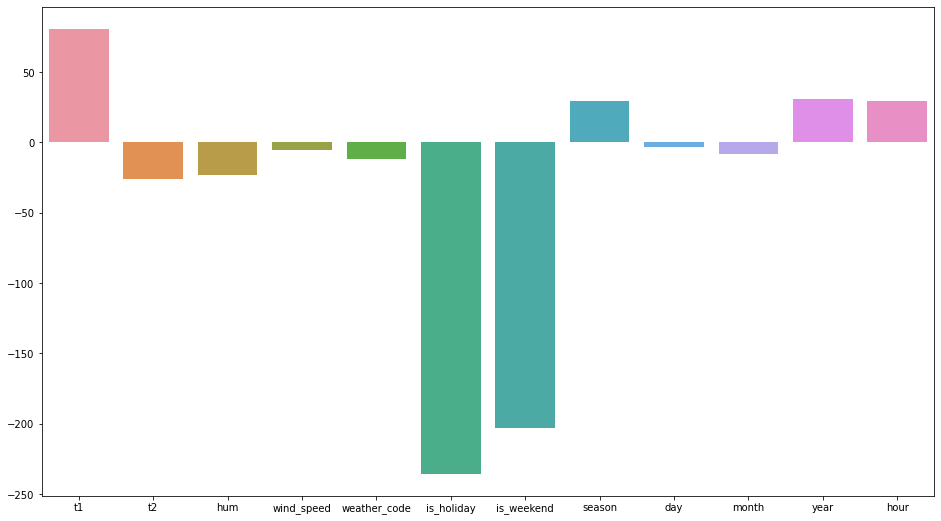

In [43]:
fig = plt.figure(figsize=(16, 9))
sns.barplot(x=X_train.columns, y=reg.coef_)

In [44]:
reg = Ridge(alpha=1)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
compute_metrics_raw(y_test, y_pred)

,MAE,MSE,RMSE,MAPE
0,677.767201,949354.121126,974.348049,172.418928


<AxesSubplot:>

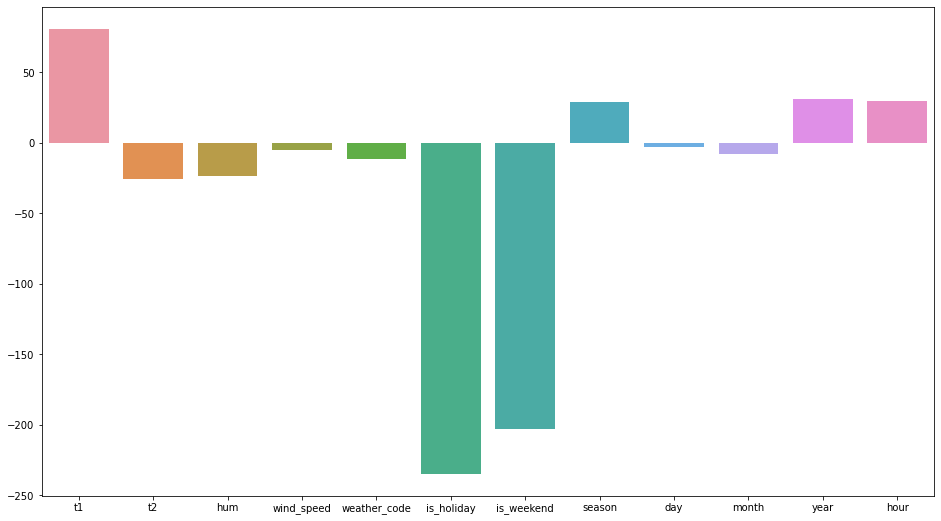

In [45]:
fig = plt.figure(figsize=(16, 9))
sns.barplot(x=X_train.columns, y=reg.coef_)

In [46]:
reg = Ridge(alpha=10)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
compute_metrics_raw(y_test, y_pred)

,MAE,MSE,RMSE,MAPE
0,677.763456,949461.771001,974.40329,172.406864


<AxesSubplot:>

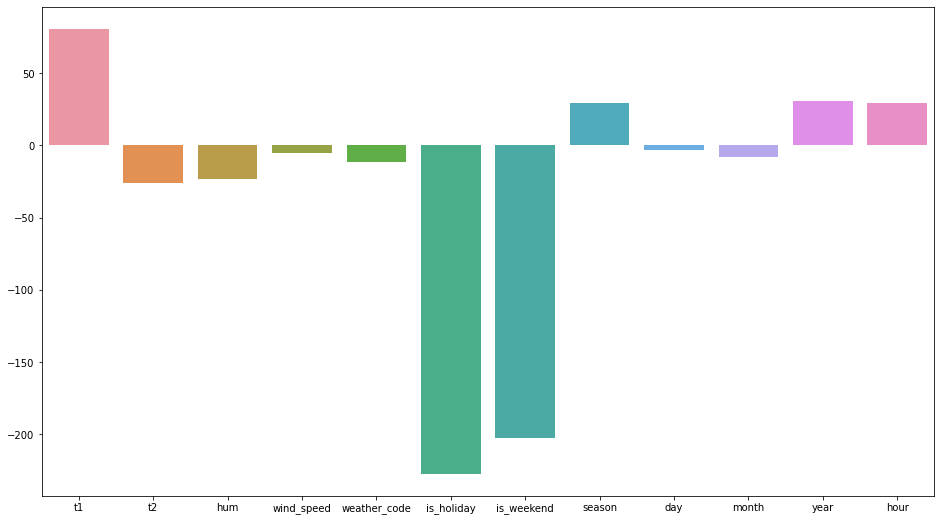

In [47]:
fig = plt.figure(figsize=(16, 9))
sns.barplot(x=X_train.columns, y=reg.coef_)

In [48]:
reg = Ridge(alpha=100)
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)
compute_metrics_raw(y_test, y_pred)

,MAE,MSE,RMSE,MAPE
0,677.721592,950432.110924,974.901078,172.371658


<AxesSubplot:>

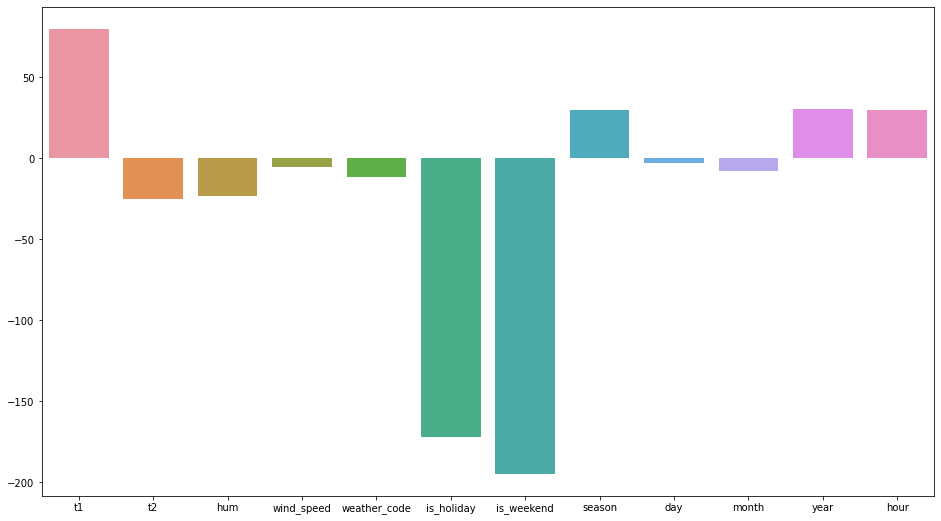

In [49]:
fig = plt.figure(figsize=(16, 9))
sns.barplot(x=X_train.columns, y=reg.coef_)

## Take a look at the Bias-Variance trade-off on this web site:

https://mlu-explain.github.io/bias-variance/

# Task (2p)
- Use the ElasticNet model (https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ElasticNet.html#sklearn.linear_model.ElasticNet)
- Use MinMax, Standard and Power Transform preprocessing together with the ElasticNet model
- Tune the *alpha* and *l1_ratio* hyper parameters
- Which setup works best out of the ones you tried?

**Write down conclusion to the Markdown cell**